# Modelos de regresión (reentrega)

El fin de este notebook es usar las ideas de `eda-reentrega.ipynb` para diseñar un modelo de regresión que nos permita explicar las características de la expectativa de vida.

Como primer paso vamos a importar las bibliotecas a utilizar y definir algunas funciones que nos van a ser de ayuda:

In [1]:
!make -C .. metnum.so
!cp ../metnum.so metnum.so

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metnum import least_squares

make: se entra en el directorio '/home/mari/Metodos/tp3'
make: 'metnum.so' está actualizado.
make: se sale del directorio '/home/mari/Metodos/tp3'


In [2]:
def normalizar(M):
    return (M - np.mean(M)) / np.std(M)

def TSS(B):
    return np.sum((B - np.mean(B))**2)

def RSS(A, X, B):
    return np.sum((B - A @ X)**2)

def R2(RSS, TSS):
    return (TSS - RSS) / TSS

def R2_ajustado(R2, N, p):
    return 1 - (1 - R2)*(N - 1)/(N - p - 1)

def residual_plot(A, X, B):
    predicted = A @ X
    residual = B - predicted
    plt.plot(predicted, residual, 'x', markersize=14)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted), )
    plt.title("Residual plot")
    return plt

def probar_modelo(A):
    mask = ~A.isna().T.any()
    # Cargamos sólo las cosas dónde tenemos todos los datos
    A = A[mask]
    # Normalizamos A
    A = normalizar(A)
    B = df['Life expectancy']
    B = normalizar(B)
    N = len(A)
    p = len(A.columns)
    X = least_squares(A, B)
    tss = TSS(B)
    rss = RSS(A, X, B)
    r2 = R2(rss, tss)
    r2_ajustado = R2_ajustado(r2, N, p)
    print()
    print(f'Features = {list(A.columns)}')
    print(f'X = {list(zip(A.columns, X))}')
    print(f'TSS = {tss}')
    print(f'RSS = {rss}')
    print(f'R^2 = {r2}')
    print(f'R^2 ajustado = {r2_ajustado}')
    plt = residual_plot(A, X, B)
    plt.show()
    print()
    return A, X, B

def vif(M):
    columns = list(M.columns)
    mask = ~M.isna().T.any()
    # Cargamos sólo las cosas dónde tenemos todos los datos
    M = M[mask].copy()
    # Normalizamos todo
    M = normalizar(M)
    for column in columns:
        A = M[[col for col in M.columns if col != column]]
        B = M[column]
        X = least_squares(A, B)
        tss = TSS(B)
        rss = RSS(A, X, B)
        r2 = R2(rss, tss)
        print(f'El VIF para {column} es {1/(1 - r2)}')

def leverage(X):
    return np.diag(X @ np.linalg.inv((X.T @ X)) @ X.T)

df = pd.read_csv('../data/dataset-completado.csv')
df.columns

Index(['Unnamed: 0', 'Country', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Status', 'Estimated road traffic death rate',
       'Age-standardized suicide rates',
       'Population using safely managed drinking-water services (%)',
       'Population using safely managed sanitation services (%)', 'Region'],
      dtype='object')

Con esto ahora podemos empezar a evaluar distintos modelos, carguemos los datos e intentemos algo muy tonto:

## Primer modelo: Usar sólo las variables categóricas


Features = ['int_status', 'int_region']
X = [('int_status', 0.21695587219595885), ('int_region', 0.6479055356798327)]
TSS = 182.99999999999994
RSS = 75.0009676200464
R^2 = 0.5901586468849922
R^2 ajustado = 0.5856048540726032


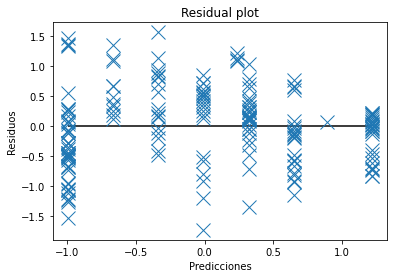

(     int_status  int_region
 0     -0.460348    0.141808
 1     -0.460348    1.159488
 2     -0.460348   -1.384712
 3     -0.460348   -1.384712
 4     -0.460348    0.650648
 ..          ...         ...
 178   -0.460348    0.650648
 179   -0.460348   -0.367032
 180   -0.460348    0.141808
 181   -0.460348   -1.384712
 182   -0.460348   -1.384712
 
 [183 rows x 2 columns],
 array([0.21695587, 0.64790554]),
 0     -1.204107
 1      0.647432
 2      0.479607
 3     -2.205603
 4      0.636517
          ...   
 178    0.454364
 179    0.605817
 180   -0.585335
 181   -1.672108
 182   -2.045281
 Name: Life expectancy, Length: 183, dtype: float64)

In [3]:
region_int_mapping = {
    # Orden basado en las densidades máximas vistas durante el análisis de los datos
    'Africa': 0,
    'South-East Asia': 1,
    'Western Pacific': 2,
    'Eastern Mediterranean': 3,
    'Americas': 4,
    'Europe': 5
}
df['int_status'] = df['Status'].apply(lambda x: 0 if x=='Developing' else 1)
df['int_region'] = df['Region'].apply(lambda x: region_int_mapping[x])
probar_modelo(df[['int_status', 'int_region']])

El residualplot no está muy bueno... Veamos de agregar el acceso a agua potable.


Features = ['int_status', 'int_region', 'Population using safely managed drinking-water services (%)']
X = [('int_status', 0.07070650806561095), ('int_region', 0.17085933651754426), ('Population using safely managed drinking-water services (%)', 0.6479366501618419)]
TSS = 182.99999999999994
RSS = 54.93341306448464
R^2 = 0.6998174149481714
R^2 ajustado = 0.6947864219026101


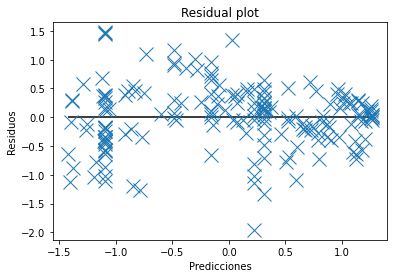

(     int_status  int_region  \
 0     -0.460348    0.141808   
 1     -0.460348    1.159488   
 2     -0.460348   -1.384712   
 3     -0.460348   -1.384712   
 4     -0.460348    0.650648   
 ..          ...         ...   
 178   -0.460348    0.650648   
 179   -0.460348   -0.367032   
 180   -0.460348    0.141808   
 181   -0.460348   -1.384712   
 182   -0.460348   -1.384712   
 
      Population using safely managed drinking-water services (%)  
 0                                            -1.407035            
 1                                            -0.002733            
 2                                             0.519877            
 3                                            -1.276468            
 4                                             0.353855            
 ..                                                 ...            
 178                                           0.353855            
 179                                          -0.104265            
 1

In [4]:
probar_modelo(df[['int_status', 'int_region', 'Population using safely managed drinking-water services (%)']])

Agregar un dato más _"de verdad"_ hizo que tome el mayor coeficiente de los tres XXXXXXXXXXXXXXXXXXXXXXXXXXx


Features = ['int_status', 'Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling']
X = [('int_status', -0.07915854758987188), ('Population using safely managed drinking-water services (%)', 0.4613004431488617), ('Estimated road traffic death rate', -0.2999001527545846), ('Schooling', 0.3255877808006731)]
TSS = 182.99999999999994
RSS = 32.933664028053215
R^2 = 0.8200346227975234
R^2 ajustado = 0.8159904570176925


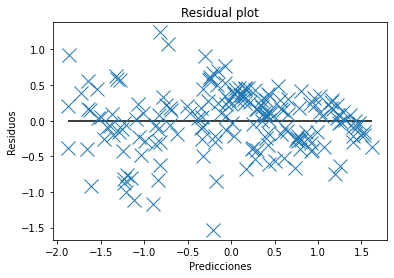

(     int_status  Population using safely managed drinking-water services (%)  \
 0     -0.460348                                          -1.407035             
 1     -0.460348                                          -0.002733             
 2     -0.460348                                           0.519877             
 3     -0.460348                                          -1.276468             
 4     -0.460348                                           0.353855             
 ..          ...                                                ...             
 178   -0.460348                                           0.353855             
 179   -0.460348                                          -0.104265             
 180   -0.460348                                           0.352899             
 181   -0.460348                                          -1.276468             
 182   -0.460348                                          -0.888380             
 
      Estimated road traff

In [5]:
probar_modelo(df[['int_status', 'Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling']])

Probamos cambiar la variable categorica buscando obtener un mejor resultado.
Usamos HIV/AIDS la cual no tiene alta correlacion con las otras variables.


Features = ['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS']
X = [('Population using safely managed drinking-water services (%)', 0.3411438634611451), ('Estimated road traffic death rate', -0.1912873593537976), ('Schooling', 0.3678866157785427), ('HIV/AIDS', -0.25064937052591774)]
TSS = 182.99999999999994
RSS = 25.483462787920764
R^2 = 0.8607461049840396
R^2 ajustado = 0.857616803972445


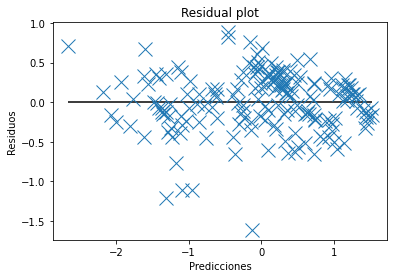

(     Population using safely managed drinking-water services (%)  \
 0                                            -1.407035             
 1                                            -0.002733             
 2                                             0.519877             
 3                                            -1.276468             
 4                                             0.353855             
 ..                                                 ...             
 178                                           0.353855             
 179                                          -0.104265             
 180                                           0.352899             
 181                                          -1.276468             
 182                                          -0.888380             
 
      Estimated road traffic death rate  Schooling  HIV/AIDS  
 0                            -0.441339  -1.227757 -0.371486  
 1                            -0.476712   0.

In [6]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS']])

Notamos un gran aumento del R2, vamos a ver la diferencia con este modelo dejando la variable categorica.


Features = ['int_status', 'Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS']
X = [('int_status', -0.04200193636055653), ('Population using safely managed drinking-water services (%)', 0.35399561436660204), ('Estimated road traffic death rate', -0.20112829293464876), ('Schooling', 0.37744924439850513), ('HIV/AIDS', -0.2450308459058752)]
TSS = 182.99999999999994
RSS = 25.28521510791783
R^2 = 0.8618294256397933
R^2 ajustado = 0.8579263020702959


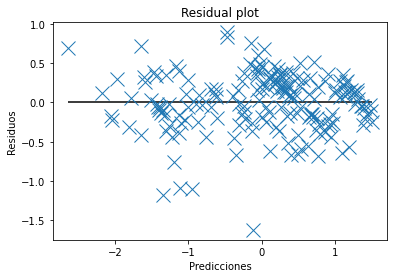

(     int_status  Population using safely managed drinking-water services (%)  \
 0     -0.460348                                          -1.407035             
 1     -0.460348                                          -0.002733             
 2     -0.460348                                           0.519877             
 3     -0.460348                                          -1.276468             
 4     -0.460348                                           0.353855             
 ..          ...                                                ...             
 178   -0.460348                                           0.353855             
 179   -0.460348                                          -0.104265             
 180   -0.460348                                           0.352899             
 181   -0.460348                                          -1.276468             
 182   -0.460348                                          -0.888380             
 
      Estimated road traff

In [7]:
probar_modelo(df[['int_status', 'Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS']])

Vemos que la diferencia es minima, con el costo de agregar una variable. Decidimos descartarla.
Queremos agregar alguna variable del grupo de vacunas, probamos con Diphtheria.


Features = ['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria']
X = [('Population using safely managed drinking-water services (%)', 0.27690970654808766), ('Estimated road traffic death rate', -0.18401637536803755), ('Schooling', 0.3072237502796338), ('HIV/AIDS', -0.2554499817781851), ('Diphtheria', 0.183172460712551)]
TSS = 182.99999999999994
RSS = 21.911310595069992
R^2 = 0.8802660623220218
R^2 ajustado = 0.8768837476983501


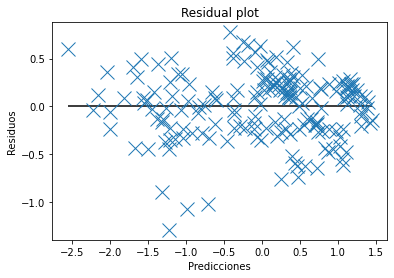

(     Population using safely managed drinking-water services (%)  \
 0                                            -1.407035             
 1                                            -0.002733             
 2                                             0.519877             
 3                                            -1.276468             
 4                                             0.353855             
 ..                                                 ...             
 178                                           0.353855             
 179                                          -0.104265             
 180                                           0.352899             
 181                                          -1.276468             
 182                                          -0.888380             
 
      Estimated road traffic death rate  Schooling  HIV/AIDS  Diphtheria  
 0                            -0.441339  -1.227757 -0.371486   -1.812956  
 1                  

In [8]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria']])

Logramos un mejor resultado, pero el numero de variables se volvio bastante alto. 
¿Que pasa si siguimos agregando features?


Features = ['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria', 'Polio']
X = [('Population using safely managed drinking-water services (%)', 0.2756420004589382), ('Estimated road traffic death rate', -0.18888045886130678), ('Schooling', 0.29855268781070804), ('HIV/AIDS', -0.2531891823499949), ('Diphtheria', 0.11587443058658276), ('Polio', 0.0757427730015217)]
TSS = 182.99999999999994
RSS = 21.8088526772215
R^2 = 0.8808259416545273
R^2 ajustado = 0.8767631896654771


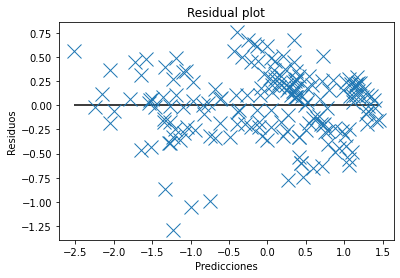

(     Population using safely managed drinking-water services (%)  \
 0                                            -1.407035             
 1                                            -0.002733             
 2                                             0.519877             
 3                                            -1.276468             
 4                                             0.353855             
 ..                                                 ...             
 178                                           0.353855             
 179                                          -0.104265             
 180                                           0.352899             
 181                                          -1.276468             
 182                                          -0.888380             
 
      Estimated road traffic death rate  Schooling  HIV/AIDS  Diphtheria  \
 0                            -0.441339  -1.227757 -0.371486   -1.812956   
 1                

In [9]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria', 'Polio']])

Notamos que agregando Polio comienza a disminuir el R2 ajustado. Como Polio y Diphtheria tienen una correlacion muy alta entre si esto tiene sentido. Probamos con 'Age-standardized suicide rates', tiene poca correlacion con la expectativa de vida, pero tambien la tiene con las otras variables por lo que podria sumar.


Features = ['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria', 'Age-standardized suicide rates']
X = [('Population using safely managed drinking-water services (%)', 0.2662690898031352), ('Estimated road traffic death rate', -0.16483290146482493), ('Schooling', 0.3339771225295822), ('HIV/AIDS', -0.22430171918174746), ('Diphtheria', 0.17609540891345182), ('Age-standardized suicide rates', -0.1137541593099114)]
TSS = 182.99999999999994
RSS = 19.901534318788457
R^2 = 0.8912484463454182
R^2 ajustado = 0.8875410070162848


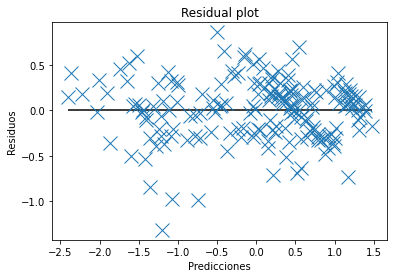

(     Population using safely managed drinking-water services (%)  \
 0                                            -1.407035             
 1                                            -0.002733             
 2                                             0.519877             
 3                                            -1.276468             
 4                                             0.353855             
 ..                                                 ...             
 178                                           0.353855             
 179                                          -0.104265             
 180                                           0.352899             
 181                                          -1.276468             
 182                                          -0.888380             
 
      Estimated road traffic death rate  Schooling  HIV/AIDS  Diphtheria  \
 0                            -0.441339  -1.227757 -0.371486   -1.812956   
 1                

In [10]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria', 'Age-standardized suicide rates']])

Se logro una gran mejora, habria que ver si puede descartarse alguna variable sin modificar notablemente el resultado